In [10]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from transforms import Affine, PReLU
from flows import Flow
tfd = tfp.distributions

In [2]:
k = 2
affine = Affine(input_dims=k, hidden_dims=k)
prelu = PReLU()
transform = affine(prelu(affine))

In [3]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros((k,)))

In [4]:
flow = Flow(base_dist, transform, name='affine_gaussian')

In [5]:
x1_samples = tfd.Normal(loc=0.0, scale=4.0).sample(512)
x2_samples = tfd.Normal(loc=0.25*tf.square(x1_samples), scale=tf.ones(512)).sample()
x_samples = tf.stack([x2_samples, x1_samples], axis=1)

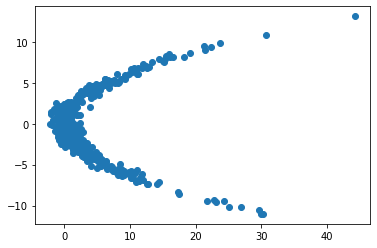

In [6]:
plt.scatter(x_samples[:,0], x_samples[:,1])

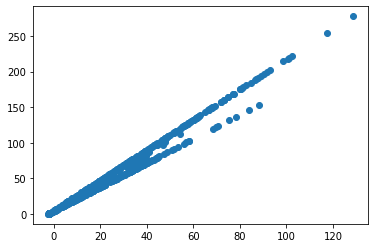

In [7]:
flow_dist_samples = flow.dist.sample(512)
plt.scatter(flow_dist_samples[:,0], flow_dist_samples[:,1])

In [20]:
k, r = 2, 2
V = tf.Variable(np.random.normal(0, 2, size=(k, r)), name=f'V', dtype=tf.float32)
L = tf.Variable(np.random.normal(0, 2, size=(k*(k+1) // 2)), name=f'L', dtype=tf.float32)
b = tf.Variable(np.random.normal(0, 2, size=(k,)), name=f'b', dtype=tf.float32)
affine_bijector = tfp.bijectors.Affine(
    scale_tril=tfp.distributions.fill_triangular(L),
    scale_perturb_factor=V,
    shift=b
)

transform_dist = tfp.distributions.TransformedDistribution(distribution=base_dist, bijector=affine_bijector)
optimizer = tf.keras.optimizers.Adam(1.0E-3)

@tf.function
def train_on_batch(X):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(transform_dist.log_prob(X))
        grads = tape.gradient(loss, [V,L,b])
        print(grads)
        optimizer.apply_gradients(zip(grads, [V,L,b]))
    return loss, grads

In [21]:
for i in range(1000000):
    log_loss, grads = train_on_batch(x_samples)
    if i % 1000 == 0:
        print(f'(iteration {i}) log loss: {log_loss.numpy()}  grads: {grads}')
    if i % 10000 == 0:
        samples = flow.dist.sample(512)
        plt.scatter(samples[:,0], samples[:,1])
        plt.show()

[None, None, None]


ValueError: No gradients provided for any variable: ['V:0', 'L:0', 'b:0'].